### esempio di lettura di un run di dati (6061) e uno di piedistalli (6060)


In [1]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy
import time
import pandas as pd

lettura info file dati:

In [ ]:
nrun = 6061
df = cy.run_info_logbook(run=nrun, sql=True, verbose=False)
df

In [ ]:
print ("esempio di uso di un sigolo elementoi {:.2f}".format(df.GEM3_V.values[0]))


lettura file dati, WARING: path e' dove si trova il file, cloud=False dice che il file vine letto in posix (quindi se si e' gia' sulla cloud va lasciato cosi) da remoto va messo cloud=True e il path diventa il luogo in cui il file vine scaricato e letto, se viene richimato lo stesso file dal path questo non vine piu' scaricato ma solamente letto 

In [19]:

mfile = cy.open_mid(run=nrun, path='/data01/data/', cloud=False, tag='', verbose=False)

for event in mfile:
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
    print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
    print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

    for bank_name, bank in event.banks.items():
        if bank_name=='DGH0': # PMTs wavform 
            header = cy.daq_dgz_full2header(bank, verbose=False)
            waveform_f, waveform_s = cy.daq_dgz_full2array(event.banks['DIG0'], header)
        if bank_name=='CAM0': # CAM image
            image, _, _ = cy.daq_cam2array(bank) # matrice delle imagine

        if bank_name=='INPT': # SLOW channels array
            slow = cy.daq_slow2array(bank)
    if event.header.serial_number == 7: 
        break

Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1675270160 containing banks DMND, MSRD, CRNT, STAT, TPTR
2023-02-01 16:49:20, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1675270160 containing banks DMND, MSRD, CRNT, STAT, TPTR
2023-02-01 16:49:20, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1675270160 containing banks DMND, MSRD
2023-02-01 16:49:20, banks DMND, MSRD
Event # 0 of type ID 7 contains banks TCAM
Received event with timestamp 1675270163 containing banks TCAM
2023-02-01 16:49:23, banks TCAM
Event # 0 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1675270165 containing banks DIG0, DGH0, CAM0
2023-02-01 16:49:25, banks DIG0, DGH0, CAM0
Event # 1 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1675270

legge le waveforms (fino alla 5 perche' 5 ne acquisimo) e ne fa un plot

fa il plot dell'ultima imagine aperta (matrice image)

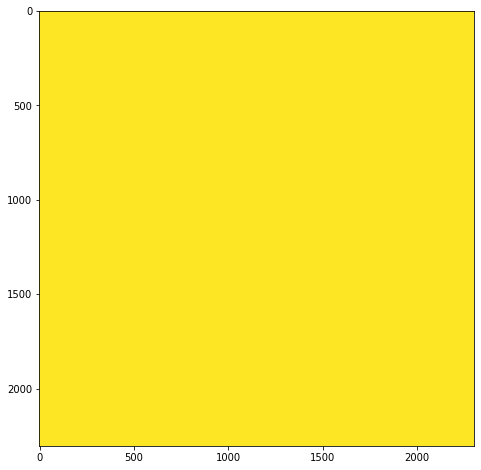

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(image, vmin=95, vmax=200)
plt.show()

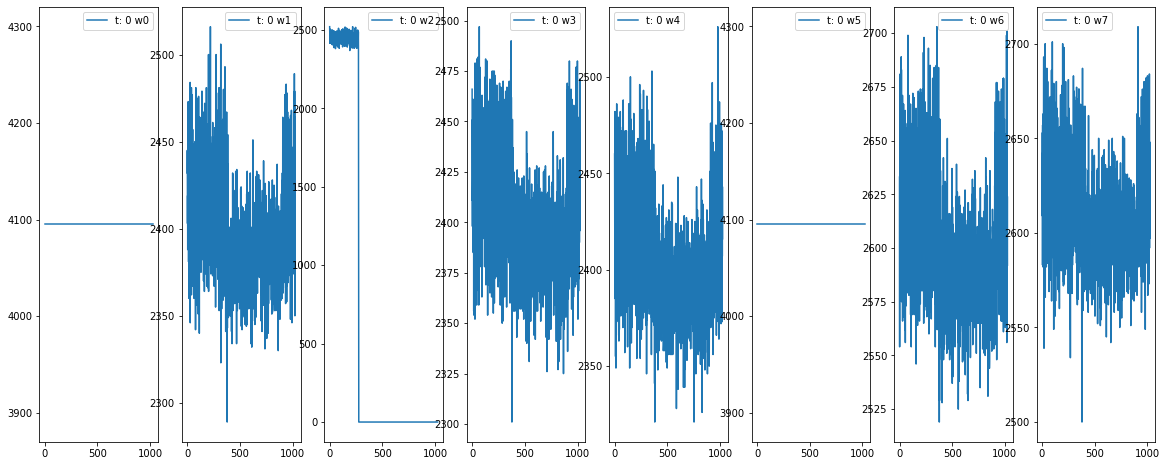

In [20]:
number_of_w_readed = 8
if header[0][0]>1:
    fig, ax = plt.subplots(header[0][0], number_of_w_readed, figsize=(20, header[1][0]))
else:
    fig, ax = plt.subplots(1, number_of_w_readed, figsize=(20, int(header[1][0])/4))
for t in range(0, header[0][0]):
    offset = t*header[1][0]
    for w in range(0, number_of_w_readed):
        if header[0][0]>1:
            ax[t,w].plot(np.linspace(0, header[2][0], header[2][0]), waveform_f[offset], 
                         label="t: {:d} w{:d}".format(t,w))
            ax[t,w].legend()
        else:
            ax[w].plot(np.linspace(0, header[2][0], header[2][0]), waveform_f[offset], 
                       label="t: {:d} w{:d}".format(t,w))
            ax[w].legend()
        offset+=1

plt.show()

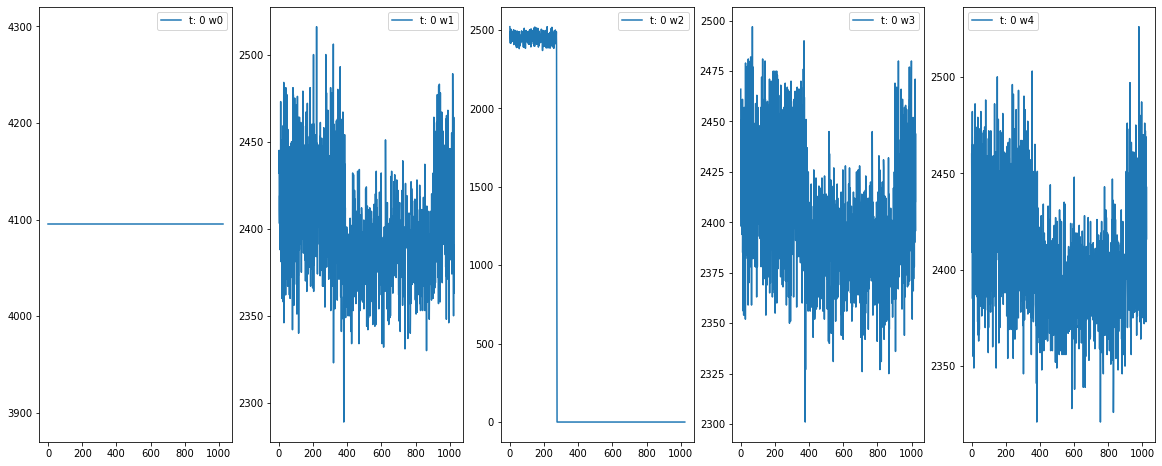

In [21]:
number_of_w_readed = 5
if header[0][0]>1:
    fig, ax = plt.subplots(header[0][1], number_of_w_readed, figsize=(10, 2*header[1][1]))
else:
    fig, ax = plt.subplots(1, number_of_w_readed, figsize=(20, int(header[1][0])/4))
for t in range(0, header[0][0]):
    offset = t*header[1][0]
    for w in range(0, number_of_w_readed):
        if header[0][0]>1:
            ax[t,w].plot(np.linspace(0, header[2][1], header[2][1]), waveform_s[offset], 
                         label="t: {:d} w{:d}".format(t,w))
            ax[t,w].legend()
        else:
            ax[w].plot(np.linspace(0, header[2][0], header[2][0]), waveform_f[offset], 
                       label="t: {:d} w{:d}".format(t,w))
            ax[w].legend()
        offset+=1

plt.show()

stampa dal db sql le informazioni sul rum di pieditalli

In [ ]:
df = cy.run_info_logbook(run=6766, sql=True, verbose=False)
df

la prossima funzione fa il piedistallo e la sigma di ogni run e li mette nella /tmp/ se vengono richiesti nuovamente questi vengono quindi letti dalla /tmp sennza rifare media e sigma

In [ ]:
m_image, s_image = cy.ped_mid(run=6060, path_file='/s3/cygno-data/', path_ped='/tmp/', tag = 'LNGS', 
            cloud=False, verbose=True)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
im = ax[0, 0].imshow(m_image, vmin=85,vmax=110)
fig.colorbar(im, ax=ax[0, 0])
ax[0, 0].set_title("mean")
ax[0, 1].set_title("sigma")
im = ax[0, 1].imshow(s_image, vmin=0,vmax=30)
fig.colorbar(im, ax=ax[0,1])
ax[1, 0].hist(m_image.ravel(), bins=256, range=(0.0, 1024.0), fc='b', ec='k')
ax[1, 1].hist(s_image.ravel(), bins=50, range=(0.0, 50.0), fc='r', ec='k')
ax[1,0].set_yscale("log")
ax[1,1].set_yscale("log")

plt.show()

plot imagine con sottrazione del piedistallo

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(image-m_image, vmin=-10,vmax=30)
fig.colorbar(im, ax=ax)
ax.set_title("ped subtracted image")
plt.show()